# Wie funktioniert Batch Normalization?

## Imports

In [0]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

!pip install --upgrade deeplearning2020
from deeplearning2020 import helpers

# jupyters magic command
%matplotlib inline

     |████████████████████████████████| 399kB 1.8MB/s 
  Created wheel for deeplearning2020: filename=deeplearning2020-0.4.18-py2.py3-none-any.whl size=8393 sha256=f7f2325a41cc4e7fbfefafea93819e719ff627538c40c590da3c15989b79774a
  Stored in directory: /root/.cache/pip/wheels/c9/24/f5/8258a898fd2cd12315ca220f208be60cc08dc29bc6bd73a0df
  Created wheel for kerasltisubmission: filename=kerasltisubmission-0.4.9-py2.py3-none-any.whl size=8867 sha256=0c1e387331e629ec52baec2b55e1f87420b6bc99194c139c20f7c503e1064c1a
  Stored in directory: /root/.cache/pip/wheels/fd/61/f7/09171376b25408ae21b58e98c9fbf2eb924f676bb77659f983
Successfully built deeplearning2020 kerasltisubmission


In [0]:
# resize the images to a uniform size
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

In [0]:
# download the dataset with labels and with information about the data
data, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

# print the most important information
dataset_size = info.splits['train'].num_examples
print('dataset size: ', dataset_size)
class_names = info.features['label'].names
print('class names: ', class_names)
n_classes = info.features['label'].num_classes
print('number of classes: ', n_classes)

batch_size = 32

try:
  train_data = tfds.load('tf_flowers', split="train[:80%]", as_supervised=True)
  test_data = tfds.load('tf_flowers', split="train[80%:100%]", as_supervised=True)
  train_data = train_data.shuffle(1000).map(preprocess).batch(batch_size).prefetch(1)
  test_data = test_data.map(preprocess).batch(batch_size).prefetch(1)
except(Exception):
  # split the data into train and test data with a 8:2 ratio
  train_split, test_split = tfds.Split.TRAIN.subsplit([8, 2])
  train_data = tfds.load('tf_flowers', split=train_split, as_supervised=True)
  test_data = tfds.load('tf_flowers', split=test_split, as_supervised=True)
  train_data = train_data.shuffle(1000).map(preprocess).batch(batch_size).prefetch(1)
  test_data = test_data.map(preprocess).batch(batch_size).prefetch(1) 

Shuffling and writing examples to /root/tensorflow_datasets/tf_flowers/3.0.0.incompleteLQLLQ6/tf_flowers-train.tfrecord


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.
dataset size:  3670
class names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
number of classes:  5


ERROR! Session/line number was not unique in database. History logging moved to new session 60


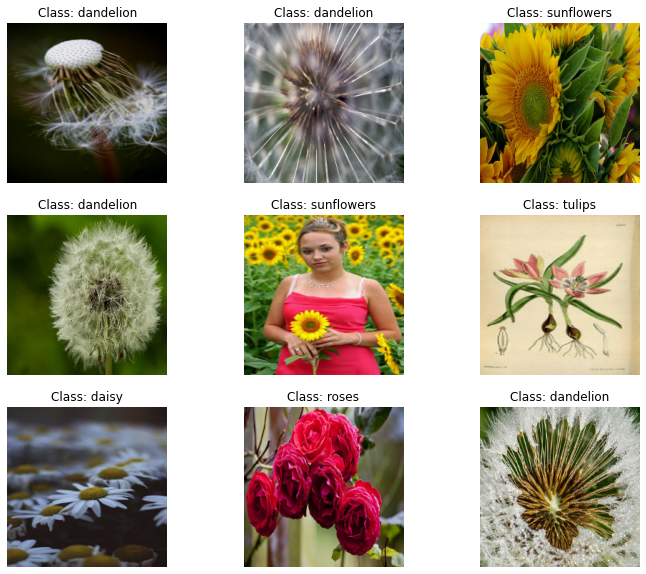

In [0]:
# show some images from the dataset
helpers.plot_images(train_data.unbatch().take(9).map(lambda x, y: (x / 255, y)), class_names)

In [0]:
# model without Batch Norm
learning_rate=0.0001
momentum=0.9
decay=0.002
dense_neurons=1000
n_filters=32
first_kernel_size=(7,7)


activation='elu'

input_layer = Input(shape=(224, 224, 3))

model = Conv2D(filters=n_filters, kernel_size=(7,7), activation=activation)(input_layer)
model = MaxPooling2D((2,2))(model)

for i in range(2, 5):
  model = Conv2D(
      filters = i * n_filters, 
      kernel_size=(3,3), 
      activation=activation
    )(model)
  model = MaxPooling2D((2,2))(model)

model = Conv2D(filters = 5 * n_filters, 
  kernel_size=(3,3), 
  activation=activation, 
  padding='same'
)(model)
model = MaxPooling2D((2,2))(model)

model = Flatten()(model)
model = Dense(dense_neurons, activation=activation)(model)

model = Dense(dense_neurons / 2, activation='tanh')(model)

output = Dense(n_classes, activation="softmax")(model)

CNN_model = Model(input_layer, output)

optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay)
CNN_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
            metrics=["accuracy"])


In [0]:
CNN_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 218, 218, 32)      4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 51, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 96)        0     

In [0]:
history = CNN_model.fit(
    train_data,
    epochs=50,
    validation_data=test_data
)

Epoch 1/50
92/92 [==============================] - 4s 48ms/step - loss: 1.5062 - accuracy: 0.3478 - val_loss: 1.3419 - val_accuracy: 0.4360
Epoch 2/50
92/92 [==============================] - 4s 43ms/step - loss: 1.2452 - accuracy: 0.4894 - val_loss: 1.1536 - val_accuracy: 0.5395
Epoch 3/50
92/92 [==============================] - 4s 44ms/step - loss: 1.1098 - accuracy: 0.5507 - val_loss: 1.0756 - val_accuracy: 0.5817
Epoch 4/50
92/92 [==============================] - 4s 44ms/step - loss: 1.0303 - accuracy: 0.5967 - val_loss: 1.0458 - val_accuracy: 0.6049
Epoch 5/50
92/92 [==============================] - 4s 44ms/step - loss: 0.9721 - accuracy: 0.6311 - val_loss: 1.0113 - val_accuracy: 0.5995
Epoch 6/50
92/92 [==============================] - 4s 44ms/step - loss: 0.9210 - accuracy: 0.6509 - val_loss: 0.9917 - val_accuracy: 0.6117
Epoch 7/50
92/92 [==============================] - 4s 44ms/step - loss: 0.8868 - accuracy: 0.6693 - val_loss: 0.9628 - val_accuracy: 0.6335
Epoch 8/50
92

In [0]:

# model with BatchNorm
learning_rate=0.0001
momentum=0.9
decay=0.002
dense_neurons=1000
n_filters=32
first_kernel_size=(7,7)


activation='elu'

input_layer = Input(shape=(224, 224, 3))

model = BatchNormalization(axis=[1, 2])(input_layer)
model = Conv2D(
    filters=n_filters, 
    kernel_size=(7,7), 
    activation=activation
    )(model)
model = BatchNormalization(axis=[1, 2])(model)
model = MaxPooling2D((2,2))(model)

for i in range(2, 5):
  model = Conv2D(
      filters = i * n_filters, 
      kernel_size=(3,3), 
      activation=activation
    )(model)
  model = BatchNormalization(axis=[1, 2])(model)
  model = MaxPooling2D((2,2))(model)

model = Conv2D(filters = 5 * n_filters, 
  kernel_size=(3,3), 
  activation=activation, 
  padding='same'
)(model)
model = BatchNormalization(axis=[1, 2])(model)
model = MaxPooling2D((2,2))(model)

model = Flatten()(model)
model = Dense(dense_neurons, activation=activation)(model)
model = BatchNormalization()(model)


model = Dense(dense_neurons / 2, activation='relu')(model)
model = BatchNormalization()(model)


output = Dense(n_classes, activation="softmax")(model)

CNN_BN_model = Model(input_layer, output)

optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay)
CNN_BN_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
            metrics=["accuracy"])

In [0]:
CNN_BN_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 3)       200704    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 218, 218, 32)      4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 218, 218, 32)      190096    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 107, 107, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 107, 107, 64)      4579

In [0]:
history_batchnorm = CNN_BN_model.fit(
    train_data,
    epochs=50,
    validation_data=test_data
)

Epoch 1/50
92/92 [==============================] - 8s 89ms/step - loss: 1.5361 - accuracy: 0.4305 - val_loss: 1.3127 - val_accuracy: 0.4591
Epoch 2/50
92/92 [==============================] - 8s 87ms/step - loss: 1.1004 - accuracy: 0.5763 - val_loss: 1.1194 - val_accuracy: 0.5586
Epoch 3/50
92/92 [==============================] - 8s 88ms/step - loss: 0.9400 - accuracy: 0.6437 - val_loss: 1.0538 - val_accuracy: 0.5858
Epoch 4/50
92/92 [==============================] - 8s 86ms/step - loss: 0.8462 - accuracy: 0.6826 - val_loss: 1.0286 - val_accuracy: 0.6008
Epoch 5/50
92/92 [==============================] - 8s 87ms/step - loss: 0.7891 - accuracy: 0.6989 - val_loss: 0.9919 - val_accuracy: 0.6185
Epoch 6/50
92/92 [==============================] - 8s 87ms/step - loss: 0.7482 - accuracy: 0.7166 - val_loss: 0.9664 - val_accuracy: 0.6226
Epoch 7/50
92/92 [==============================] - 8s 87ms/step - loss: 0.6985 - accuracy: 0.7510 - val_loss: 0.9609 - val_accuracy: 0.6240
Epoch 8/50
92

## Visualization

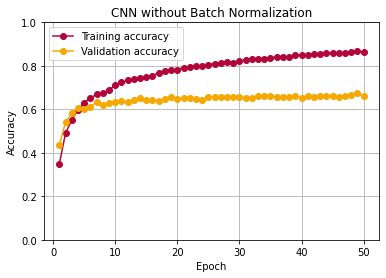

In [0]:
helpers.plot_history('CNN without Batch Normalization', history, 0)
# validation accuracy might be sometimes higher than training accuracy due to 2 reasons:
#     - train acc is calculated as the mean of the whole epoch, test acc is calculated after each epoch
#       (where the model is better than in the mid of the epoch)
#     - when you use e.g. Dropout, the behavior at training time is different 

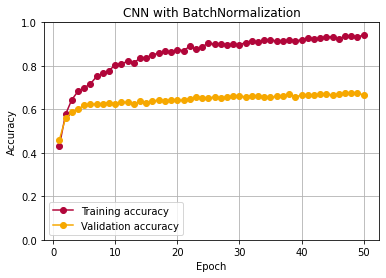

In [0]:
helpers.plot_history('CNN with BatchNormalization', history_batchnorm, 0)